## process C3D files into time series of marker data
- c3d file is a F x n x (x,y,z) dimension file, where F = number of frames, n = number of markers detected from acquisition
- labels are stored in reader.point_labels

In [2]:
import c3d 
import numpy as np
import matplotlib.pyplot as plt
import tools
import math

In [25]:
# sampling rate is 200 Hz
# Open the .c3d file
with open('/Users/anqizhou/FastTrack/sampleData_11-15-2024/Sain_2019_11_15_DAp_GBMOV_T1_OFF_GNG_GAIT_001.c3d', 'rb') as f:
    reader = c3d.Reader(f)
    
    # Initialize data structures to store extracted data
    markers = []
    frame_numbers = []

    # Iterate over frames
    #for i, (points, analog) in enumerate(reader.read_frames()):
    for i, points in enumerate(reader.read_frames()):
        frame_numbers.append(i)
        markers.append(points[1][:,:3])  # Extract 3D positions (x, y, z), which are the first three values stored in the 1st tuple position
        #analog_data.append(analog)    # Extract analog signals (e.g., force plates)

# Convert to numpy arrays for easier manipulation
markers = np.array(markers)        # Shape: (frames, markers, (x,y,z))
markers = np.transpose(markers, (1, 2, 0)) # change the shape so that it is (markers, (x,y,z), frames)

# find indices along the 1st dim of the markers array to find labels that are already annotated
# untraced marker labels are numbered with asterisks (e.g. *36, *37)
marker_indices = [i for i, element in enumerate(reader.point_labels) if '*' not in element]

# create a dataset with label dictionary
data = {
    'marker_labels': reader.point_labels[marker_indices],
    'time_series_raw': tools.replace_zeros_with_neighbors_mean(markers[marker_indices],1),
    # to clean the data, let's assume that processes are linear over 3 timesteps (+1/-1 on each side)
    # or 
    # complete raw data
    #'time_series_raw': markers 
}

# visualize the raw data

/var/folders/jt/2d34l4_56p77x5t1814hvn2w0000gn/T/ipykernel_1244/2070912572.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


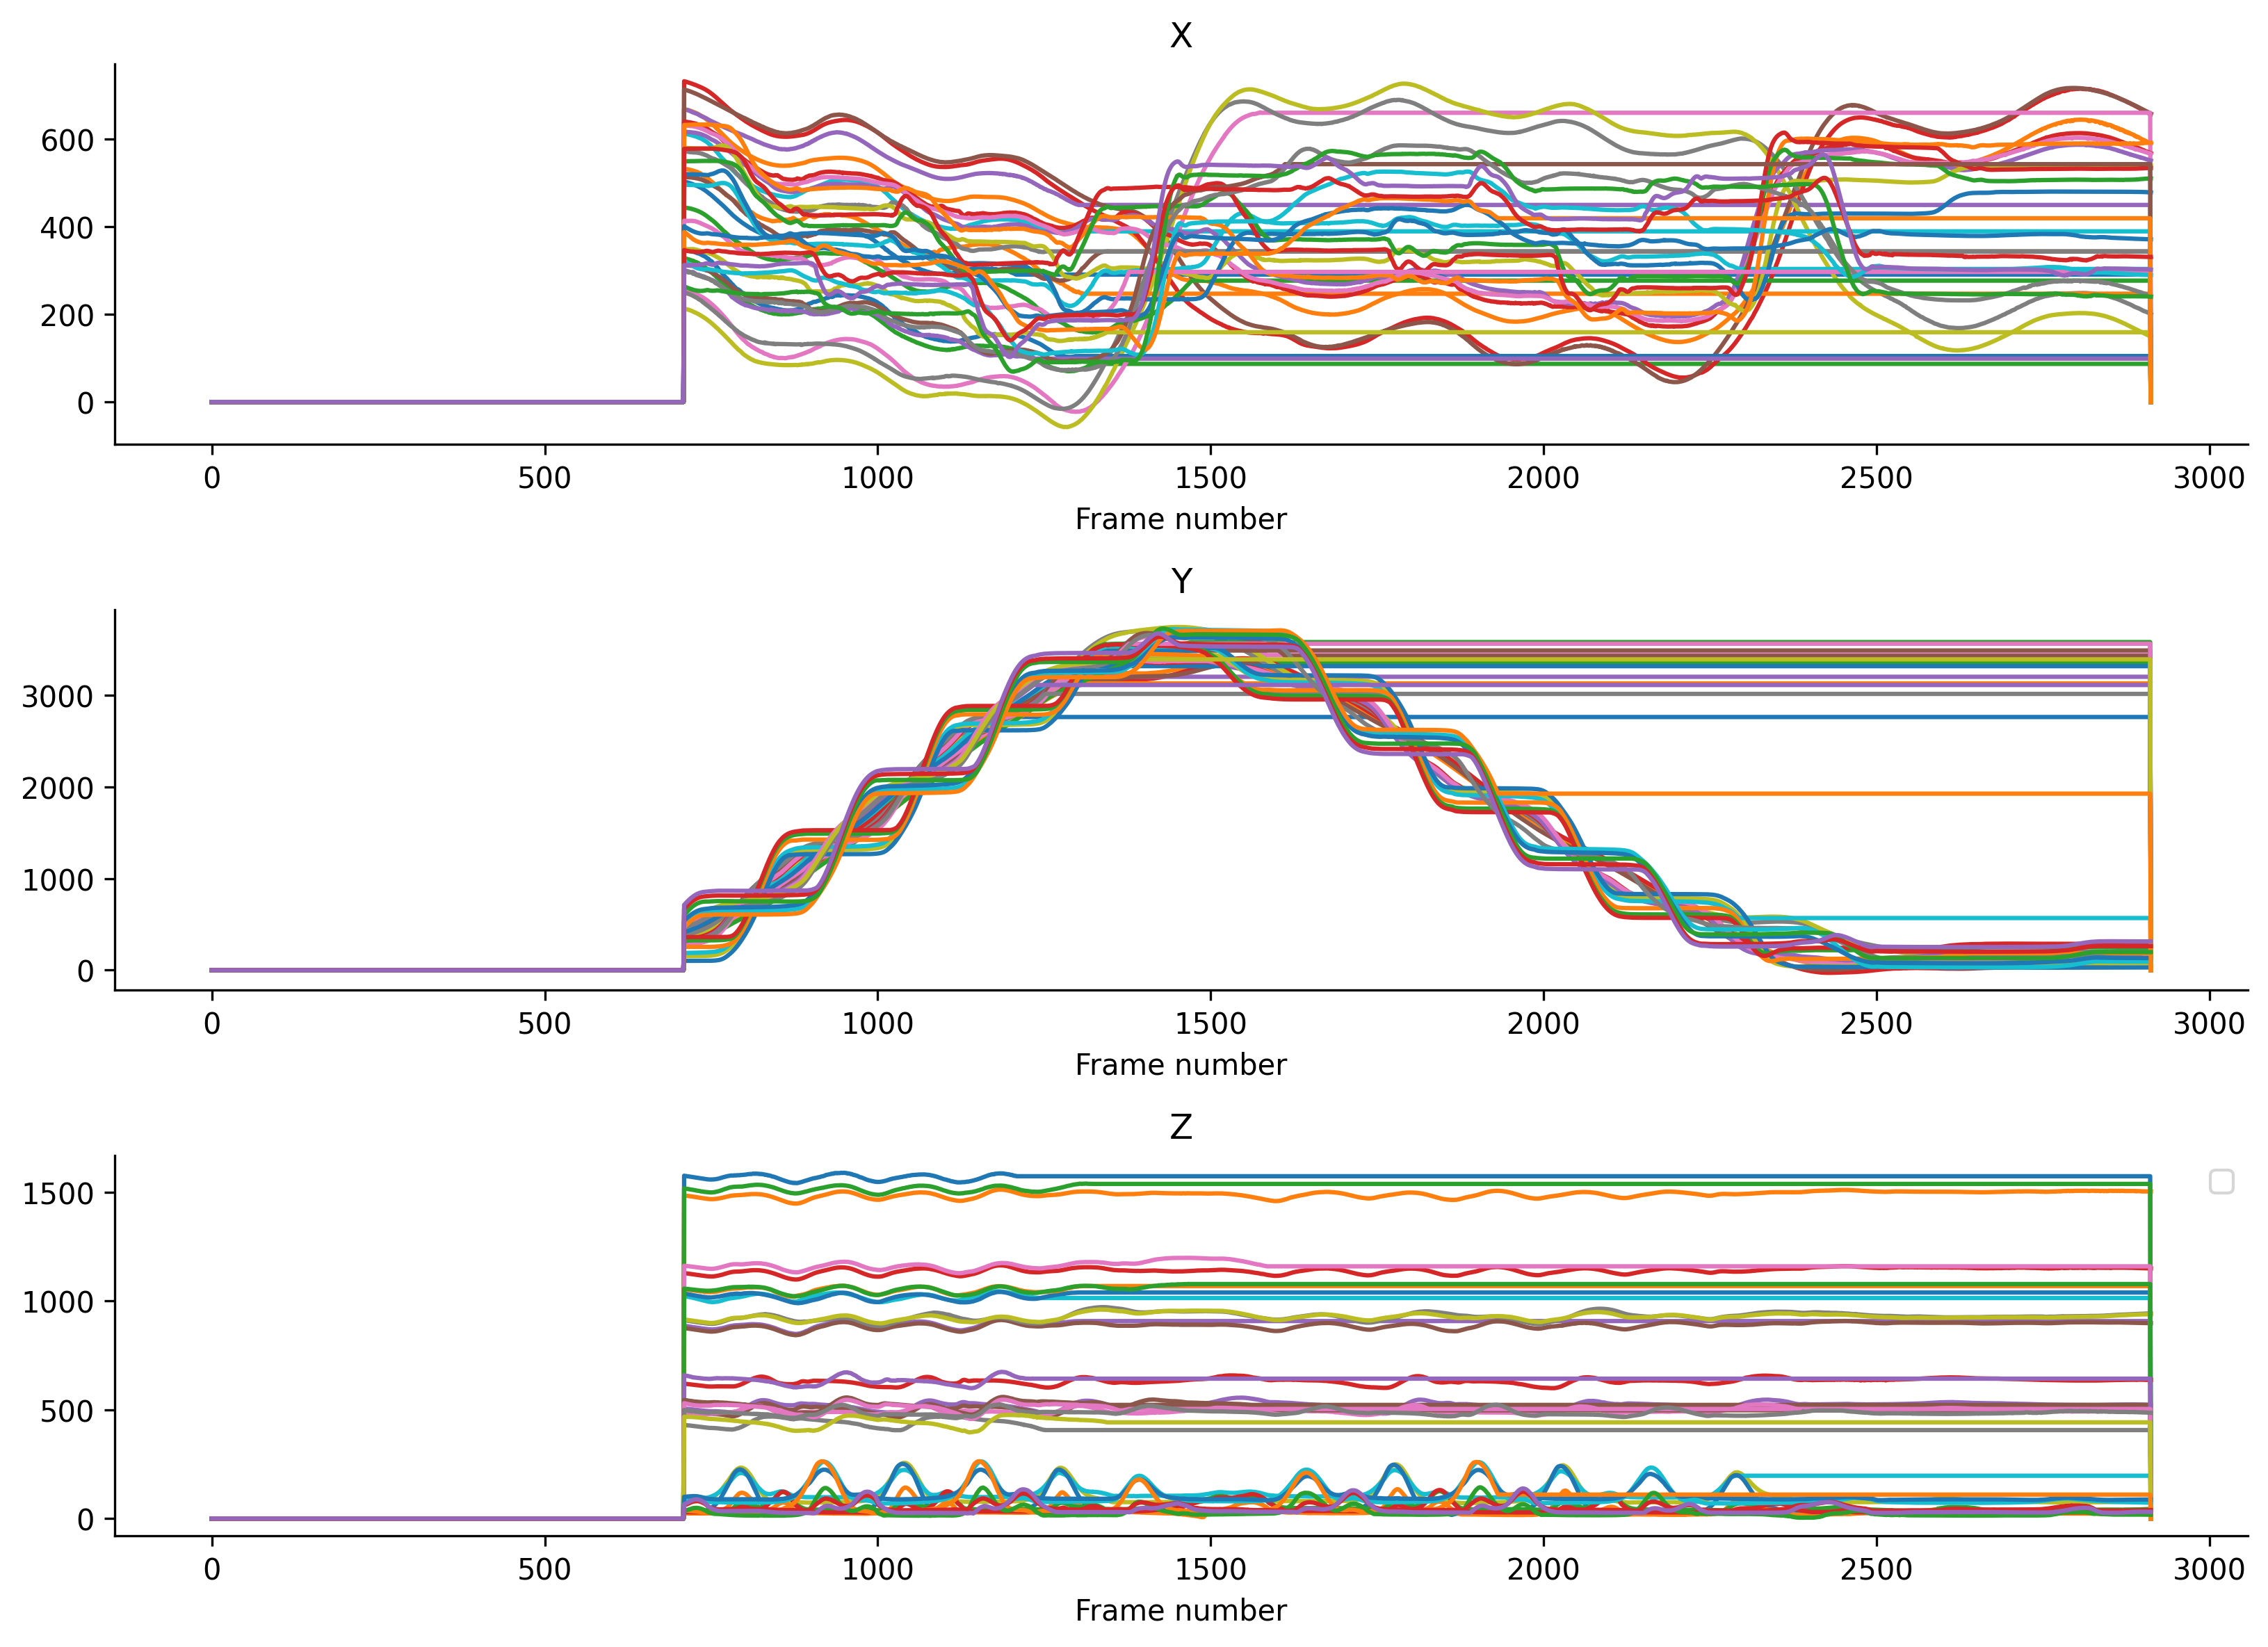

In [26]:
# x,y,z info for each marker i is stored as data['time_series_raw'][i][0], [i][1], or [i][2]
plot_title = ['X','Y','Z']
fig,axs = plt.subplots(3,1, figsize=(11,8), dpi=300, tight_layout = True)
for d in range(3): # recursive over three dimensions
    for i in range(len(data['marker_labels'])): # plot line for each marker
        axs[d].plot(np.linspace(0, len(data['time_series_raw'][0][0]), num=len(data['time_series_raw'][0][0])), 
            data['time_series_raw'][i][d], 
            #label=data['marker_labels'][i]
        )
    axs[d].set_title(plot_title[d])
    axs[d].set_xlabel('Frame number')

    axs[d].spines.right.set_visible(False)
    axs[d].spines.top.set_visible(False)
#plt.savefig('{}/lineplot.svg'.format(output), format='svg')
#plt.savefig('{}/lineplot.pdf'.format(output), format='pdf')
plt.legend()
plt.show()

# Egocentric measurement
- let's find a central point between all markers, assuming that the markers are uniformly distributed
- convert the markers from space coordinates into vector coordinates from the center

In [27]:
center = np.mean(data['time_series_raw'], axis=0)

# transform marker data
ego = []
for i in range(len(data['marker_labels'])):
    ego.append(data['time_series_raw'][i] - center) # compute euclidean distance
ego = np.array(ego)

# now normalize by the size of vector
magnitude=[]
for i in range(len(data['marker_labels'])):
    for t in range(len(ego[i,0])):
        # compute square root of sum of squares across position for all axes
        # to compute magnitude of the vector
        magnitude.append(math.hypot(ego[i,0,t], ego[i,1,t], ego[i,2,t]))
magnitude = np.reshape(np.array(magnitude),(len(data['marker_labels']),len(ego[i,0])))
# broadcast and normalize the coordinates
ego_normalized = ego/magnitude[:,np.newaxis,:]
ego_normalized = {'time_series_centered': np.array(ego_normalized)}
data.update(ego_normalized)

/var/folders/jt/2d34l4_56p77x5t1814hvn2w0000gn/T/ipykernel_1244/3120012293.py:18: RuntimeWarning: invalid value encountered in divide
  ego_normalized = ego/magnitude[:,np.newaxis,:]


/var/folders/jt/2d34l4_56p77x5t1814hvn2w0000gn/T/ipykernel_1244/3138451650.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


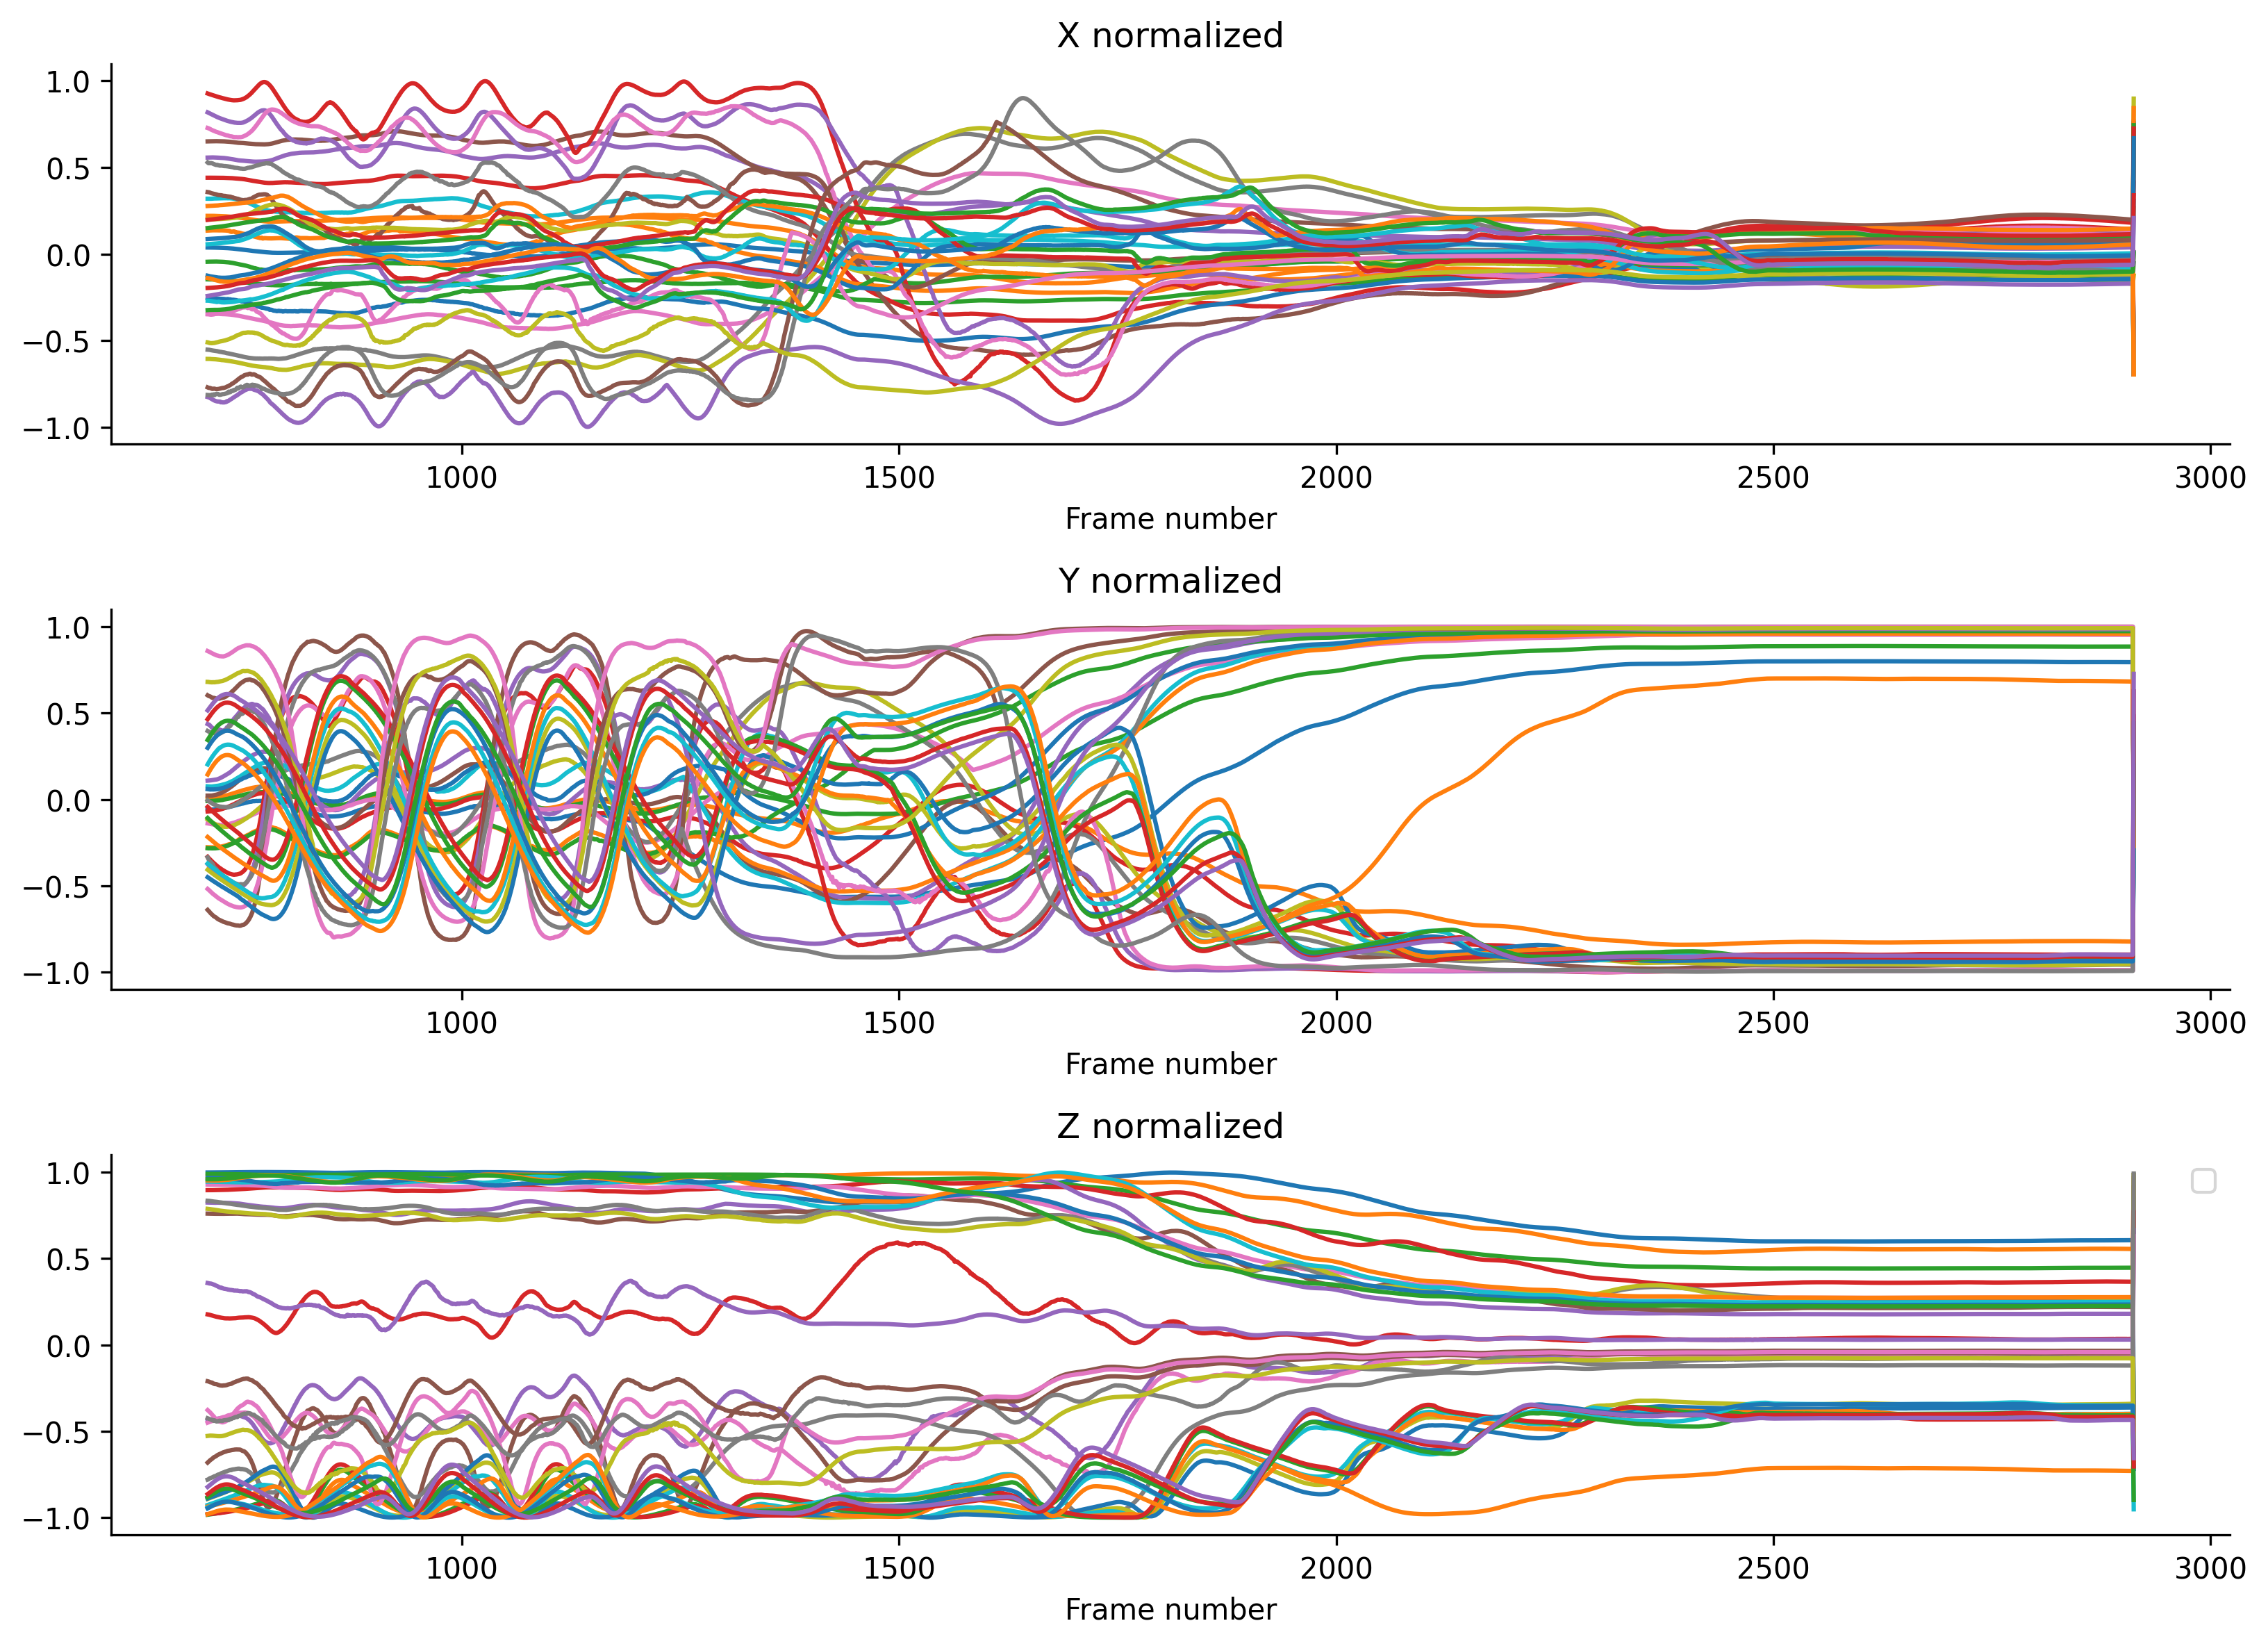

In [29]:
# x,y,z info for each marker i is stored as data['time_series_raw'][i][0], [i][1], or [i][2]
plot_title = ['X normalized','Y normalized','Z normalized']
fig,axs = plt.subplots(3,1, figsize=(11,8), dpi=300, tight_layout = True)
for d in range(3): # recursive over three dimensions
    for i in range(len(data['marker_labels'])): # plot line for each marker
        axs[d].plot(np.linspace(0, len(data['time_series_raw'][0][0]), num=len(data['time_series_raw'][0][0])), 
            data['time_series_centered'][i][d], 
            #label=data['marker_labels'][i]
        )
    axs[d].set_title(plot_title[d])
    axs[d].set_xlabel('Frame number')

    axs[d].spines.right.set_visible(False)
    axs[d].spines.top.set_visible(False)
#plt.savefig('{}/lineplot.svg'.format(output), format='svg')
#plt.savefig('{}/lineplot.pdf'.format(output), format='pdf')
plt.legend()
plt.show()

In [ ]:
# random forest classifier
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# X shape: (72, 3, 2917)
X_flat = X.reshape(72, -1)  # Flatten to shape (72, 3*2917)
y = y.flatten()  # Flatten y to shape (72, )

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_flat, y, test_size=0.2, random_state=42)

# Train a classifier (Random Forest in this case)
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")


In [ ]:
# CNN/RNN approach
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

# X shape: (72, 3, 2917)
X = np.array(X)
y = np.array(y)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build a simple 1D CNN model
model = Sequential()
model.add(Conv1D(64, 3, activation='relu', input_shape=(X.shape[1], X.shape[2])))
model.add(Dropout(0.5))
model.add(Conv1D(128, 3, activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Use softmax if there are multiple classes

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=8, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Accuracy: {accuracy}")